In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cuda:0


In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [5]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

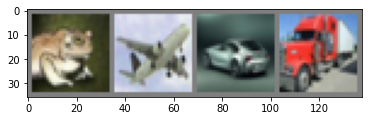

frog  plane car   truck


In [6]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [7]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [9]:
 net = net.to(device)

In [10]:
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.904
[1,  4000] loss: 1.649
[1,  6000] loss: 1.562
[1,  8000] loss: 1.495
[1, 10000] loss: 1.454
[1, 12000] loss: 1.385
[2,  2000] loss: 1.328
[2,  4000] loss: 1.328
[2,  6000] loss: 1.308
[2,  8000] loss: 1.306
[2, 10000] loss: 1.255
[2, 12000] loss: 1.276
[3,  2000] loss: 1.176
[3,  4000] loss: 1.217
[3,  6000] loss: 1.194
[3,  8000] loss: 1.164
[3, 10000] loss: 1.166
[3, 12000] loss: 1.173
[4,  2000] loss: 1.099
[4,  4000] loss: 1.105
[4,  6000] loss: 1.125
[4,  8000] loss: 1.085
[4, 10000] loss: 1.120
[4, 12000] loss: 1.121
[5,  2000] loss: 1.038
[5,  4000] loss: 1.051
[5,  6000] loss: 1.055
[5,  8000] loss: 1.058
[5, 10000] loss: 1.086
[5, 12000] loss: 1.044
[6,  2000] loss: 0.988
[6,  4000] loss: 1.005
[6,  6000] loss: 1.039
[6,  8000] loss: 1.024
[6, 10000] loss: 1.003
[6, 12000] loss: 1.034
[7,  2000] loss: 0.957
[7,  4000] loss: 0.954
[7,  6000] loss: 0.974
[7,  8000] loss: 0.991
[7, 10000] loss: 1.005
[7, 12000] loss: 0.987
[8,  2000] loss: 0.935
[8,  4000] 

In [11]:
PATH = './cifar_net20220421.pth'
torch.save(net.state_dict(), PATH)

In [12]:
net = Net()
net = net.to(device)
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [13]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 62 %


In [14]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 57.6 %
Accuracy for class: car   is 74.3 %
Accuracy for class: bird  is 60.2 %
Accuracy for class: cat   is 44.8 %
Accuracy for class: deer  is 52.3 %
Accuracy for class: dog   is 52.3 %
Accuracy for class: frog  is 72.5 %
Accuracy for class: horse is 69.3 %
Accuracy for class: ship  is 78.2 %
Accuracy for class: truck is 66.5 %
